---

## [미니프로젝트] 서울시 공유자전거 '따릉이'의 수요 예측

### 여러분은 서울시 정책 연구원으로서 서울시 공유자전거인 '따릉이'의 수요와 날씨간 연관성을 분석하라는 미션을 부여받았습니다.

#### <font color="blue"> 데이터 분석의 주 목적은 가치있는 정보를 찾아내는것!! </font>

### ▣ 우리가 풀어야 하는 문제는 무엇인가요?

 - 어떠한 날씨요소가 따릉이 수요와 관련 있는지 분석하여 인사이트를 도출해봅시다

---

## ▣ 데이터 소개
[기본 데이터]
* 데이터 : sbikedata.csv

## ▣ 데이터셋의 변수 소개
* date : 날짜
* hour : 시간
* temperature : 온도
* precipitation : 강우 여부, 비가 오지 않았으면 0, 비가 오면 1
* windspeed : 풍속(평균)
* humidity : 습도
* visibility : 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
* ozone : 오존 수치
* PM10 : 미세먼지 수치(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
* PM2.5 : 초미세먼지 수치(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
* count : 시간에 따른 따릉이 대여 수

---

### [Step1] 환경 설정
#### <span style="color: green"> 1) 라이브러리 불러오기 </span>

In [1]:
#EDA에 사용할 라이브러리를 import 하세요
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 파이썬 모든 행과 모든 열을 다 볼 수 있게 하는 설정
# 모든 행과 열의 최대 표시 설정 변경
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#### <span style="color: green"> 2) 활용할 데이터 불러오기 </span>

In [2]:
#이번 프로젝트에서 분석할 데이터를 불러오세요
df = pd.read_csv('sbikedata.csv')
display(df.head())
display(df.tail())


,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
0,2021-04-01,1,42.0,21.0,0.002,13.1,0,1.4,49,2000,46
1,2021-04-01,2,41.0,21.0,0.003,12.4,0,2.1,53,2000,40
2,2021-04-01,3,30.0,13.0,0.023,13.1,0,3.4,43,2000,31
3,2021-04-01,4,27.0,12.0,0.028,13.0,0,3.1,44,2000,12
4,2021-04-01,5,29.0,14.0,0.008,13.0,0,2.9,44,2000,30


,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
5822,2021-11-29,20,74.0,58.0,0.002,9.3,0,0.3,66,1193,273
5823,2021-11-29,21,65.0,56.0,0.002,8.4,0,2.0,70,1233,228
5824,2021-11-29,22,51.0,41.0,0.002,8.6,0,1.9,70,1250,215
5825,2021-11-29,23,43.0,35.0,0.001,8.2,0,2.1,71,1262,125
5826,2021-11-30,0,39.0,31.0,0.004,7.9,0,2.3,71,1483,95


### [Step2] 가설설정
#### '가설' 이란 단어를 생각해보면, 우리가 직접 가설을 만들어야 할것 같지만 통계에서 분석기법별 귀무가설/대립가설은 정해져있습니다.
- 귀무가설은 차이가 없다, 연관성이 없다, 효과가 없다.
- 대립가설은 차이가 있다, 연관성이 있다, 효과가 있다. 라고 간단하게 이해하시면 좋습니다.

#### 간단한 예로, 온도와 따릉이 대여량간 가설을 수립 해본다면

    - 귀무가설 : 온도와 따릉이 간에는 연관성이 없다.
    - 대립가설 : 온도와 따릉이 간에는 연관성이 있다.

로 가설이 자연스레 수립 됩니다.



---


#### <span style="color: green"> 5개 이상의 Feature와 따릉이 대여량 간 가설을 수립해주세요. </span>

##### Guide : Target은 따릉이 대여량 입니다.

#### 가설 1 : 날짜(date)가 자전저 대여량(count)과 연관이 있는가?
               - 어떠한 달이 자전거 대여량이 높은가?
                  -> 4월, 6월, 9월, 10월이 자전거 대여량 합 평균이 높은 것으로 집계된다.
                  
               - 날짜(date)를 월요일, 화요일, 수요일, 목요일, 금요일, 토요일, 일요일로 분류하여 어떠한 요일에 자전거 대여량이 많은가?
                   -> 수요일, 목요일, 금요일이 자전거 대여량 합 평균이 높은 것으로 집계된다.

#### 가설 2 : 시간대(date)가 자전거 대여량(count)와 연관이 있는가?
               - 시간대(date)를  새벽(ex. 0 <= < 6), 아침(ex. 6 <= < 9), 오전 (ex. 9 <= < 12), 점심 (ex. 12 <= < 14), 오후(ex. 14 <= < 18), 
               저녁 (ex. 18 <= < 22), 밤 (ex. 22 <=  < 24)으로 구분하여 어떠한 시간대가 자전거 대여량이 높은가?
                   -> 오후, 저녁 시간대 (14시 ~ 21시)에 자전거 대여량이 많은 것을 알 수 있다.

#### 가설 3 : 미세먼지(PM10)이 자전거 대여량(count)와 연관이 있는가?
              - 미세먼지(PM10)을 좋음 (0 <= < 31), 보통 (31 <=  < 81), 나쁨 (81 <=  < 151), 매우 나쁨 (151 <=  < 250), 위험 (250 <= < 828)으로 분류하여
                 -> 미세먼지 보통(31 ~ 80)일 떄 자전거 대여량이 높았다.
                 
#### 가설 4 : 온도(temperature)가 자전거 대여량(count)와 연관이 있는가?
              - 온도를  쌀쌀한 날씨: (-3.5 <= < 0), 서늘한 날씨(0 <= < 10), 따뜻한 날씨: (10 <= < 25), 더운 날씨: (25 <= < 30), 
                        매우 더운 날씨: (30 <= < 36.4)로 분류하여 온도가 어떠한 겨울에 자전거 대여량이 높은지 확인한다.
                -> 더운 날씨, 매우 더운 날씨 (25 ~ 36.4)에서 자전거 대여량이 높은 것을 알 수 있다.

####  가설 5 : 강우 여부(precipitation)가 자전거 대여량(count)와 연관이 있는가?
               -> 강우 여부와 자전거 대여량은 강한 연관을 가지며
                  비가 내리지 않을 떄 자전거 대여량은 높은 것을 알 수 있다.



####  가설 6 : 풍속(windspeed)가 자전거 대여량(count)와 연관이 있는가?
           - 풍속을 바람 없음(0 <= < 0.3), 약한 바람: (0.3 <= < 3.3), 
             약간 강한 바람: (3.4 <= < 8.0), 강한 바람: (8.0 <= < 10.0)으로 분류하여 
             어떠한 풍속일 떄 자전거 대여량이 높은지 확인한다.
             -> 약한 강한 바람(3.4 ~ 7.9)일 떄 자전거 대여량이 평균적으로 높다.
             
#### 가설 7 : 습도(humidity)가 자전거 대여량(count)와 연관이 있는가?
           - 습도(humidity) 건조: (19 <=  < 41), 보통: (41 <=  < 60), 습함: (61 <= < 80), 매우 습함: (81 <= < 101)으로 분류하여
            어떠한 습도일 떄 자전거 대여량이 높은지 확인한다

### [Step3] 단변량 분석

단변량 분석은 데이터분석의 매우 기초적인 분석기법으로, 독립적인 개별 변수가 가지고있는 특성들을 이해하는 과정입니다.

<span style="color: green"> 개별 변수에 대해 아래 사항들을 분석해보세요. </span>

1. 변수가 내포하고 있는 의미
2. 변수가 수치형인지, 범주형인지
3. 결측치 존재 여부 및 조치 방안
4. 기초 통계량 확인
5. 데이터 분포 확인
6. 위 정보로부터 파악한 내용 정리
7. 추가 분석사항 도출

### Feature1 : hour

1. 변수가 내포하고 있는 의미

- 변수의 의미를 한번 짚고 넘어갑시다.
hour 변수는 어떤 의미를 가지고 있나요?

2. 변수가 수치형인지 범주형인지


In [4]:
#변수의 자료형을 확인해보세요.
df["hour"].dtype

dtype('int64')

* 시간대를 나타내는 hour은 수치형이다.
* 자료형은 int

3. 변수의 결측치 존재 여부 및 조치방안

In [5]:
#변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 

4. 변수의 기초 통계량 확인

In [6]:
#변수의 기초 통계량을 확인해보세요.

5. 변수의 분포 확인

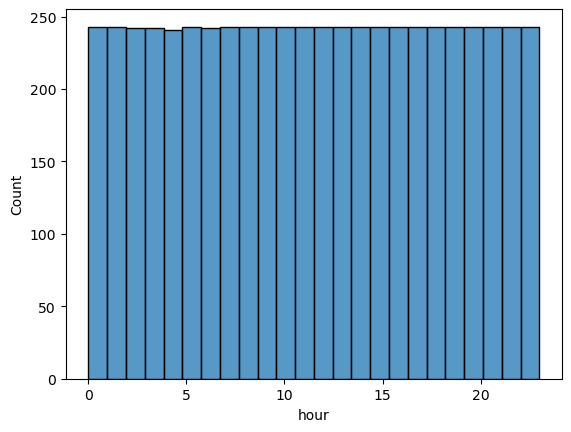

In [7]:
#변수의 분포를 확인해보세요.
sns.histplot(x=df["hour"], bins=24)
plt.show()

6. 위 정보로 부터 파악한 내용 정리

In [8]:
#위 정보로부터 파악하신 내용을 정리해보세요.

7. 추가 분석사항 도출

In [9]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.

### Feature2 : temperature

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

2. 변수가 수치형인지 범주형인지


In [10]:
#변수의 자료형을 확인해보세요.
df["temperature"].dtype

dtype('float64')

* 온도(temperature)는 수치형이고
* 자료형은 float이다.

3. 변수의 결측치 존재 여부 및 조치방안

In [11]:
#변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 
df["temperature"].isna().sum()

0

4. 변수의 기초 통계량 확인

In [12]:
#변수의 기초 통계량을 확인해보세요

5. 변수의 분포 확인

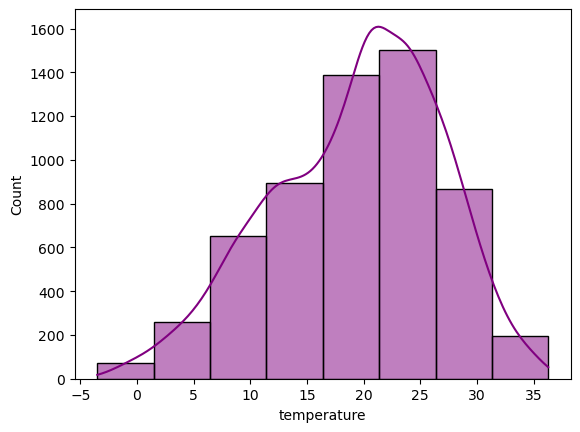

In [13]:
#변수의 분포를 확인해보세요.
sns.histplot(x=df["temperature"], bins=8, kde=True, color="purple")
plt.show()

6. 위 정보로 부터 파악한 내용 정리

In [14]:
#위 정보로부터 파악하신 내용을 정리해보세요.

* 약 16도에서 26도의 온도 데이터가 많다.
* 즉 따듯한 온도의 데이터가 많은 것을 알 수 있다.

7. 추가 분석사항 도출

In [15]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.

### Feature3 : precipitation

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

2. 변수가 수치형인지 범주형인지


In [16]:
#변수의 자료형을 확인해보세요.
df["precipitation"].dtype

dtype('int64')

* 강우 여부를 나타내는 'precipitaion'은 범주형이고
* 자료형은 int이다.

3. 변수의 결측치 존재 여부 및 조치방안

In [17]:
#변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 
df["precipitation"].isna().sum()

0

4. 변수의 기초 통계량 확인

In [18]:
#변수의 기초 통계량을 확인해보세요

5. 변수의 분포 확인

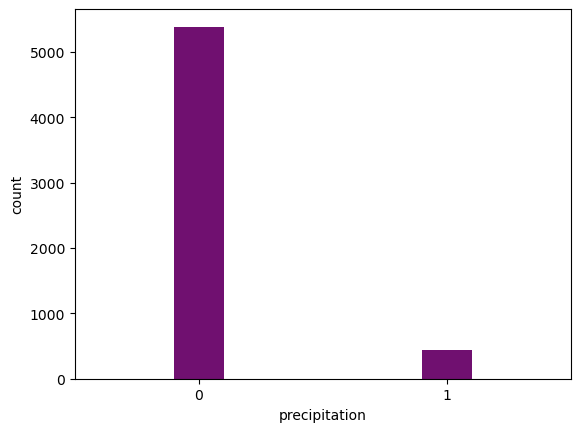

In [19]:
#변수의 분포를 확인해보세요.
sns.countplot(x=df["precipitation"], width=0.2, color="purple")
plt.show()

In [20]:
# 전체 데이터
row = df.shape[0]

# 비가 오지 않는 데이터 건수(확률)
precipitaion_0 = df.loc[df["precipitation"] == 0].shape[0]
display(precipitaion_0 / row * 100)

# 비가 오는 데이터 건수(확률)
precipitaion_1 = df.loc[df["precipitation"] == 1].shape[0]
display(precipitaion_1 / row * 100)


92.44894456838854

7.551055431611465

6. 위 정보로 부터 파악한 내용 정리

In [21]:
#위 정보로부터 파악하신 내용을 정리해보세요.

* 전체 데이터 5827개 중에 약 92퍼는 비가 오지 않는 데이터, 나머지 약 8퍼는 비가 오는 데이터로 구성되어 있는 것을 알 수 있다.

7. 추가 분석사항 도출

In [22]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.

### Feature4 : windspeed

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

2. 변수가 수치형인지 범주형인지


In [23]:
#변수의 자료형을 확인해보세요.
df["windspeed"].dtype

dtype('float64')

* 풍속(windspeed)은 수치형이고
* 자료형은 float이다.

3. 변수의 결측치 존재 여부 및 조치방안

In [24]:
#변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 
df["windspeed"].isna().sum()

0

4. 변수의 기초 통계량 확인

In [25]:
#변수의 기초 통계량을 확인해보세요

5. 변수의 분포 확인

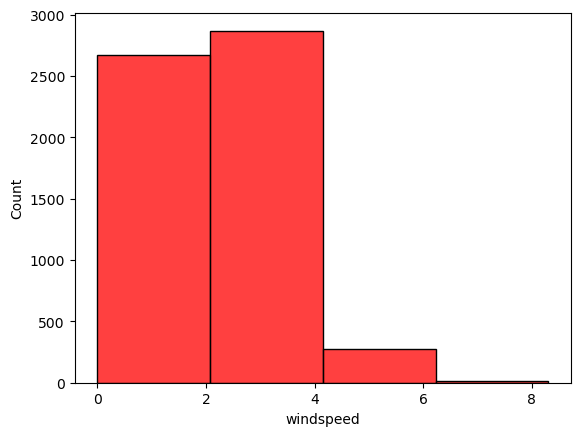

In [26]:
#변수의 분포를 확인해보세요.
sns.histplot(x=df["windspeed"], bins=4, color="red")
plt.show()

6. 위 정보로 부터 파악한 내용 정리

In [27]:
#위 정보로부터 파악하신 내용을 정리해보세요.

* 바람이 없거나 약한 바람일 떄 데이터 건수가 많은 것을 알 수 있다. 

7. 추가 분석사항 도출

In [28]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.

### Feature5 : humidity

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

2. 변수가 수치형인지 범주형인지


In [29]:
#변수의 자료형을 확인해보세요.
df["humidity"].dtype

dtype('int64')

* 습도(humidity)는 수치형이며
* 자료형은 int이다.

3. 변수의 결측치 존재 여부 및 조치방안

In [30]:
#변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 
df["humidity"].isna().sum()

0

4. 변수의 기초 통계량 확인

In [31]:
#변수의 기초 통계량을 확인해보세요

5. 변수의 분포 확인

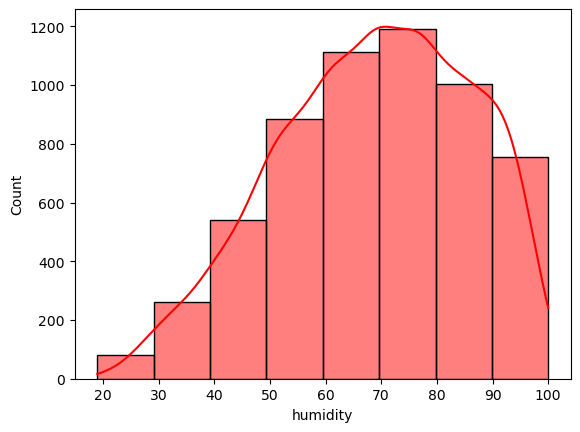

In [32]:
#변수의 분포를 확인해보세요.
sns.histplot(x=df["humidity"], bins=8, color="red", kde=True)
plt.show()

* 습도가 60 ~ 90인 즉 습함, 매우 습함 데이터가 많은 것을 알 수 있다.

6. 위 정보로 부터 파악한 내용 정리

In [33]:
#위 정보로부터 파악하신 내용을 정리해보세요.

7. 추가 분석사항 도출

In [34]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.

### Feature6 : visibility

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

2. 변수가 수치형인지 범주형인지


In [35]:
#변수의 자료형을 확인해보세요.

3. 변수의 결측치 존재 여부 및 조치방안

In [36]:
#변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 

4. 변수의 기초 통계량 확인

In [37]:
#변수의 기초 통계량을 확인해보세요

5. 변수의 분포 확인

In [38]:
#변수의 분포를 확인해보세요.

6. 위 정보로 부터 파악한 내용 정리

In [39]:
#위 정보로부터 파악하신 내용을 정리해보세요.

7. 추가 분석사항 도출

In [40]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.

### Feature7 : ozone

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

2. 변수가 수치형인지 범주형인지


In [41]:
#변수의 자료형을 확인해보세요.
df["ozone"].dtype

dtype('float64')

* 오존(ozone)은 수치형
* 자료형은 float이다.

3. 변수의 결측치 존재 여부 및 조치방안

In [42]:
#변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 
display(df["ozone"].isna().sum())
display(df["ozone"].unique())

128

array([0.002, 0.003, 0.023, 0.028, 0.008, 0.009, 0.018, 0.027, 0.032,
       0.033, 0.038, 0.042, 0.044, 0.045, 0.043, 0.039, 0.037, 0.036,
       0.034, 0.04 , 0.035, 0.041, 0.025, 0.01 , 0.015, 0.006, 0.022,
       0.019, 0.03 , 0.026, 0.021, 0.017, 0.031, 0.029, 0.024, 0.02 ,
       0.016, 0.004, 0.049, 0.053, 0.055, 0.059, 0.06 , 0.051, 0.046,
       0.012, 0.013, 0.014, 0.047, 0.05 , 0.058, 0.052, 0.007, 0.056,
         nan, 0.066, 0.057, 0.011, 0.054, 0.065, 0.067, 0.07 , 0.077,
       0.072, 0.005, 0.064, 0.068, 0.071, 0.061, 0.074, 0.069, 0.048,
       0.063, 0.079, 0.106, 0.104, 0.085, 0.075, 0.081, 0.073, 0.08 ,
       0.062, 0.078, 0.088, 0.107, 0.11 , 0.116, 0.087, 0.082, 0.097,
       0.099, 0.094, 0.086, 0.083, 0.09 , 0.093, 0.084, 0.076, 0.089,
       0.1  , 0.137, 0.115, 0.092, 0.098, 0.103, 0.096, 0.111, 0.118,
       0.101, 0.001])

In [43]:
# 결측치는 오존 평균값으로 대체한다.
ozone_not_null_datas = df[df['ozone'].notna()]
ozone_mean = ozone_not_null_datas["ozone"].sum() / ozone_not_null_datas.shape[0]
df["ozone"] = df["ozone"].fillna(ozone_mean)
df["ozone"].isna().sum()

0

4. 변수의 기초 통계량 확인

In [44]:
#변수의 기초 통계량을 확인해보세요

5. 변수의 분포 확인

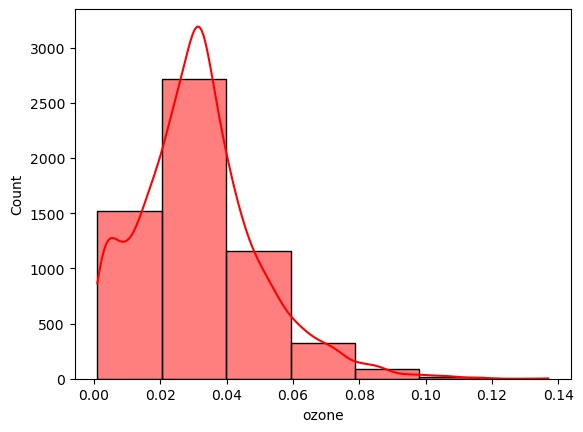

In [45]:
#변수의 분포를 확인해보세요.
sns.histplot(x=df["ozone"], bins=7, color="red", kde=True)
plt.show()

6. 위 정보로 부터 파악한 내용 정리

In [46]:
#위 정보로부터 파악하신 내용을 정리해보세요.

7. 추가 분석사항 도출

In [47]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.

### Feature8 : PM10

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

2. 변수가 수치형인지 범주형인지


In [48]:
#변수의 자료형을 확인해보세요.
df["PM10"].dtype

dtype('float64')

* 미세먼지(PM10)은 수치형
* 자료형은 float

3. 변수의 결측치 존재 여부 및 조치방안

In [49]:
#변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 
df["PM10"].isna().sum()

102

In [50]:
# 결측치는 미세먼지(PM10)의 평균으로 대치한다.
PM10_not_null_datas = df[df['PM10'].notna()]
PM10_average = PM10_not_null_datas["PM10"].sum() / PM10_not_null_datas.shape[0]
df["PM10"] = df["PM10"].fillna(PM10_average)
df["PM10"].isna().sum()

0

In [50]:
# 결측치는 미세먼지(PM10)의 평균으로 대치한다.
PM10_not_null_datas = df[df['PM10'].notna()]
PM10_average = PM10_not_null_datas["PM10"].sum() / PM10_not_null_datas.shape[0]
df["PM10"] = df["PM10"].fillna(PM10_average)
df["PM10"].isna().sum()

0

4. 변수의 기초 통계량 확인

In [51]:
#변수의 기초 통계량을 확인해보세요


5. 변수의 분포 확인

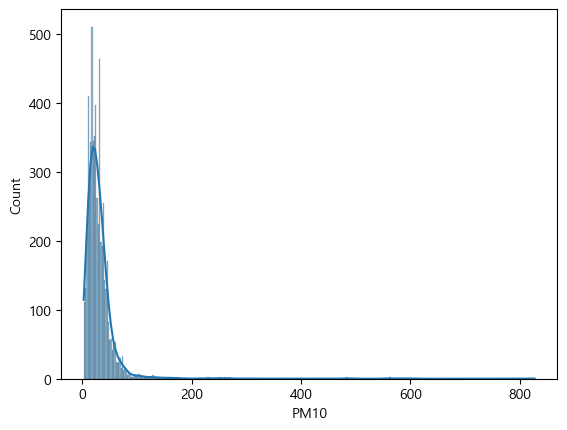

In [117]:
sns.histplot(x=df["PM10"], kde=True)
plt.show()

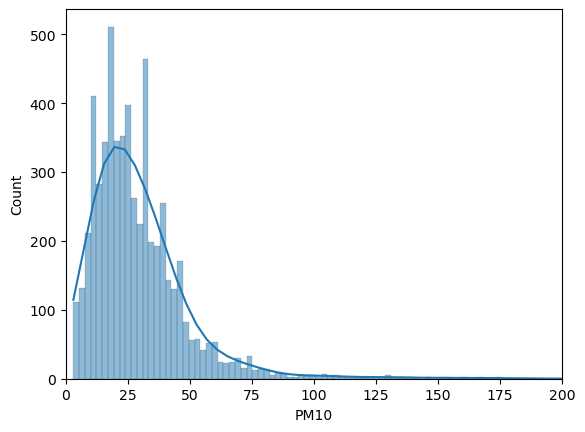

In [52]:
#변수의 분포를 확인해보세요.
# 미세먼지(PM10)을 좋음 (0 <= < 31), 보통 (31 <=  < 80), 나쁨 (81 <=  < 150), 매우 나쁨 (151 <=  < 250), 위험 (250 <= < 828)으로 분류
sns.histplot(x=df["PM10"], kde=True)
plt.xlim(0, 200)
plt.show()

* 미세먼지가 좋음, 보통인 데이터들이 많다.

6. 위 정보로 부터 파악한 내용 정리

In [53]:
#위 정보로부터 파악하신 내용을 정리해보세요.

7. 추가 분석사항 도출

In [54]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.

### Feature9 : PM2.5

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

2. 변수가 수치형인지 범주형인지


In [55]:
#변수의 자료형을 확인해보세요.

3. 변수의 결측치 존재 여부 및 조치방안

In [56]:
#변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 
# 결측치 값은 PM2.5의 평균값으로 대치한다.
PM25_not_null_datas = df[df["PM2.5"].notnull()]
PM25_average = PM25_not_null_datas["PM2.5"].sum() / PM25_not_null_datas.shape[0]
df["PM2.5"] = df["PM2.5"].fillna(PM25_average)
df["PM2.5"].unique()

array([ 21.        ,  13.        ,  12.        ,  14.        ,
        10.        ,   9.        ,   8.        ,  16.        ,
        11.        ,   7.        ,  18.        ,  19.        ,
        24.        ,  22.        ,  20.        ,  17.        ,
        15.        ,   4.        ,   6.        ,   5.        ,
         1.        ,   2.        ,   3.        ,  26.        ,
        29.        ,  28.        ,  27.        ,  25.        ,
        35.        ,  39.        ,  40.        ,  44.        ,
        55.        ,  60.        ,  62.        ,  58.        ,
        56.        ,  54.        ,  32.        ,  23.        ,
        31.        ,  33.        ,  15.66660851,  30.        ,
        57.        ,  34.        ,  37.        ,  38.        ,
        36.        ,  43.        ,  47.        ,  41.        ,
        42.        ,  49.        ,  59.        ,  52.        ,
        50.        ,  78.        ,  88.        ,  89.        ,
        93.        ,  94.        ,  87.        ,  86.  

4. 변수의 기초 통계량 확인

In [57]:
#변수의 기초 통계량을 확인해보세요

5. 변수의 분포 확인

In [58]:
#변수의 분포를 확인해보세요.

6. 위 정보로 부터 파악한 내용 정리

In [59]:
#위 정보로부터 파악하신 내용을 정리해보세요.

7. 추가 분석사항 도출

In [60]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.

### Count (Target)

1. 변수가 내포하고 있는 의미
- 변수의 의미를 한번 짚고 넘어갑시다. 여러분이 생각하는 이 변수의 의미를 작성해보세요.

2. 변수가 수치형인지 범주형인지


In [61]:
#변수의 자료형을 확인해보세요.
df["count"].dtype

dtype('int64')

* 자전거 대여량(count)은 수치형이며
* 자료형은 int이다.

3. 변수의 결측치 존재 여부 및 조치방안

In [62]:
#변수의 결측치 존재 여부를 확인하고, 만약 결측치가 존재하면 어떻게 처리할지 고민해보세요. 

4. 변수의 기초 통계량 확인

In [63]:
#변수의 기초 통계량을 확인해보세요

5. 변수의 분포 확인

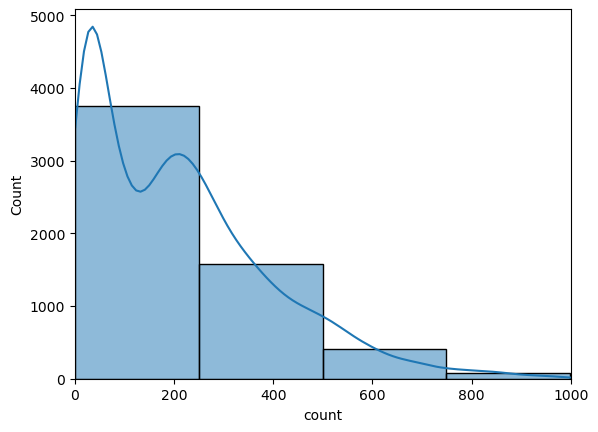

In [64]:
#변수의 분포를 확인해보세요.
sns.histplot(x=df["count"], bins=7, kde=True)
plt.xlim(0, 1000)
plt.show()

* 자전거 대여량이 0 ~ 200 데이터가 가장 많다.

6. 위 정보로 부터 파악한 내용 정리

In [65]:
#위 정보로부터 파악하신 내용을 정리해보세요.

7. 추가 분석사항 도출

In [66]:
#추가로 분석을 원하는 부분이 있다면 분석후 정리해보세요.

### [Step4] 이변량 분석 
* 자료의 종류에 맞게 X --> Y 에 대해서 그래프(시각화)와 가설검정(수치화)을 수행하고 결과를 평가합니다.
* 가설검정시 다음의 항목을 참조하여 수행합니다.
    * 적절한 유의수준
    * 숫자 --> 숫자 : 상관분석
    * 범주 --> 범주 : 카이제곱검정
    * 범주 --> 숫자 : t검정, 분산분석
    * 숫자 --> 범주 : 로지스틱 회귀모형을 통해, 회귀계수의 P.value로 검정을 수행합니다.

#### 가설 1 : 날짜(date)가 자전저 대여량(count)과 연관이 있는가?
               - 어떠한 달이 자전거 대여량이 높은가?
                  -> 4월, 6월, 9월, 10월이 자전거 대여량 합 평균이 높은 것으로 집계된다.
                  
               - 날짜(date)를 월요일, 화요일, 수요일, 목요일, 금요일, 토요일, 일요일로 분류하여 어떠한 요일에 자전거 대여량이 많은가?
                   -> 수요일, 목요일, 금요일이 자전거 대여량 합 평균이 높은 것으로 집계된다.

#### 가설 2 : 시간대(date)가 자전거 대여량(count)와 연관이 있는가?
               - 시간대(date)를  새벽(ex. 0 <= < 6), 아침(ex. 6 <= < 9), 오전 (ex. 9 <= < 12), 점심 (ex. 12 <= < 14), 오후(ex. 14 <= < 18), 
               저녁 (ex. 18 <= < 22), 밤 (ex. 22 <=  < 24)으로 구분하여 어떠한 시간대가 자전거 대여량이 높은가?
                   -> 오후, 저녁 시간대 (14시 ~ 21시)에 자전거 대여량이 많은 것을 알 수 있다.

#### 가설 3 : 미세먼지(PM10)이 자전거 대여량(count)와 연관이 있는가?
              - 미세먼지(PM10)을 좋음 (0 <= < 31), 보통 (31 <=  < 81), 나쁨 (81 <=  < 151), 매우 나쁨 (151 <=  < 250), 위험 (250 <= < 828)으로 분류하여
                 -> 미세먼지 보통(31 ~ 80)일 떄 자전거 대여량이 높았다.
                 
#### 가설 4 : 온도(temperature)가 자전거 대여량(count)와 연관이 있는가?
              - 온도를  쌀쌀한 날씨: (-3.5 <= < 0), 서늘한 날씨(0 <= < 10), 따뜻한 날씨: (10 <= < 25), 더운 날씨: (25 <= < 30), 
                        매우 더운 날씨: (30 <= < 36.4)로 분류하여 온도가 어떠한 겨울에 자전거 대여량이 높은지 확인한다.
                -> 더운 날씨, 매우 더운 날씨 (25 ~ 36.4)에서 자전거 대여량이 높은 것을 알 수 있다.

####  가설 5 : 강우 여부(precipitation)가 자전거 대여량(count)와 연관이 있는가?
               -> 강우 여부와 자전거 대여량은 강한 연관을 가지며
                  비가 내리지 않을 떄 자전거 대여량은 높은 것을 알 수 있다.



####  가설 6 : 풍속(windspeed)가 자전거 대여량(count)와 연관이 있는가?
           - 풍속을 바람 없음(0 <= < 0.3), 약한 바람: (0.3 <= < 3.3), 
             약간 강한 바람: (3.4 <= < 8.0), 강한 바람: (8.0 <= < 10.0)으로 분류하여 
             어떠한 풍속일 떄 자전거 대여량이 높은지 확인한다.
             -> 약한 강한 바람(3.4 ~ 7.9)일 떄 자전거 대여량이 평균적으로 높다.
             
#### 가설 7 : 습도(humidity)가 자전거 대여량(count)와 연관이 있는가?
           - 습도(humidity) 건조: (19 <=  < 41), 보통: (41 <=  < 60), 습함: (61 <= < 80), 매우 습함: (81 <= < 101)으로 분류하여
            어떠한 습도일 떄 자전거 대여량이 높은지 확인한다
            -> 습도가 보통 ~ 건조(19 ~ 59)일 떄 자전거 대여량이 비교적 높은 것을 알 수 있다.

In [67]:
# 데이터
df.head()
# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

#### (1) 범주형 Feature --> 숫자형 Y (따릉이 대여 Count)

<font color="green">* 모든 범주형 Feature에 대해서 Y와 비교하여 차트를 그리고 수치화 하시오.</font>


        1. 시각화 : 그래프를 활용한 데이터 분석
        2. 수치화 : t-test, anova
        3. 관계 평가 (가설 검정)

1. 날짜(date)를 4월, 5월 ... 11월로 범주화 -> 따릉이 대여량간 이변량 분석

In [68]:
# 날짜를 4월, 5월 ... 11월로 범주화하여 새로운 열 "month"를 만든다.
df["date"] = pd.to_datetime(df["date"])
df["month"] = df["date"].dt.month
df["month"] = df["month"].astype(str)
df["month"] = df["month"] + "월"

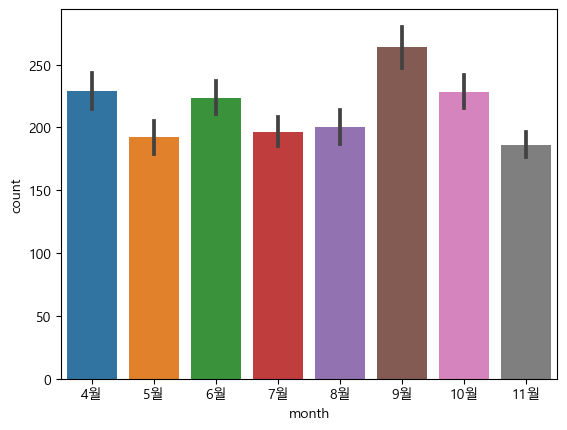

F_onewayResult(statistic=14.418555266868342, pvalue=1.0250409939149756e-18)

In [69]:
# 시각화
# x축 : 4월, 5월, ...., 11월
# y축 : 4월의 자전거 대여량 합 평균, 5월의 자전거 대여량 합 평균 ...., 11월의 자전거 대여량 합 평균
sns.barplot(x=df["month"], y=df["count"])
plt.show()

# 수치화
L = []
for element in df["month"].unique():
    L.append(df.loc[df["month"] == element, "count"])
stats.f_oneway(*L)

* F 통계량이 약 14이며, pvalue가 0에 수렴하므로 유의미하다고 볼 수 있다.
* 4월, 6월, 9월, 10월이 자전거 대여량 합 평균이 높다고 볼 수 있다.

2. 날짜(date)를 가지고 일요일, 월요일..., 금요일으로 범주화 -> 따릉이 대여량 간 이변량 분석

In [70]:
# 날짜(date)를 가지고 평일(Weekday), 주말(Weekend)으로 범주화 한다.
df["day"] = df["date"].dt.weekday
df["day"] = df["day"].map({
    0 : "월요일",
    1 : "화요일",
    2 : "수요일",
    3 : "목요일",
    4 : "금요일",
    5 : "토요일",
    6 : "일요일",
})
# 순서를 원하는대로 지정
custom_order = ['일요일', '월요일', '화요일', '수요일', '목요일', '금요일', '토요일']
# 데이터프레임의 'day' 열을 Categorical로 변환하여 순서 지정
df['day'] = pd.Categorical(df['day'], categories=custom_order, ordered=True)
df.head()

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count,month,day
0,2021-04-01,1,42.0,21.0,0.002,13.1,0,1.4,49,2000,46,4월,목요일
1,2021-04-01,2,41.0,21.0,0.003,12.4,0,2.1,53,2000,40,4월,목요일
2,2021-04-01,3,30.0,13.0,0.023,13.1,0,3.4,43,2000,31,4월,목요일
3,2021-04-01,4,27.0,12.0,0.028,13.0,0,3.1,44,2000,12,4월,목요일
4,2021-04-01,5,29.0,14.0,0.008,13.0,0,2.9,44,2000,30,4월,목요일


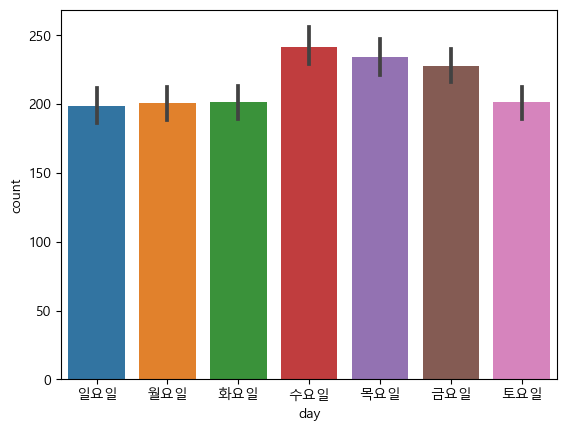

F_onewayResult(statistic=8.317297883731852, pvalue=5.378942897976812e-09)

In [71]:
# 시각화
# x축 : 월요일, 화요일, ... , 일요일
# y축 : 월요일일 떄 자전거 대여량 합의 평균, 화요일일 떄 자전거 대여량 합의 평균, .... 일요일일 떄 자전거 대여량 합의 평균
sns.barplot(x=df["day"], y=df["count"])
plt.show()

# 수치화
L = []
for element in df["day"].unique():
    L.append(df.loc[df["day"] == element, "count"])
stats.f_oneway(*L)

* 요일과 자전거 대여량의 관계는 유의미하다고 볼 수 있다.
* 수요일, 목요일, 금요일이 자전거 대여량 합 평균이 높다고 볼 수 있다.

2. 강수 여부와 따릉이 대여량간 이변량 분석

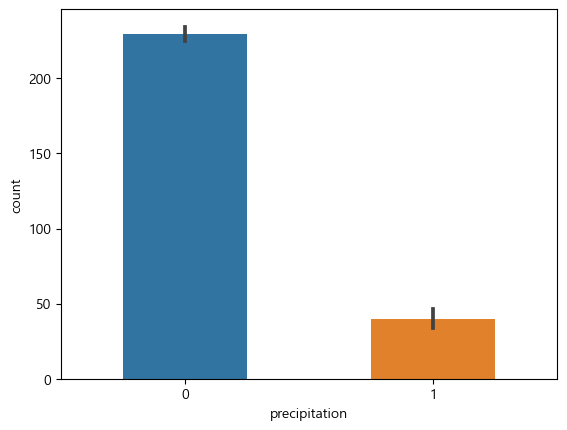

Ttest_indResult(statistic=21.389614151911022, pvalue=8.86239184041254e-98)

In [72]:
# 시각화
# x축 : precipitation 0, 1  
# y축 : precipitation이 0일 떄 자전거 대여량 합의 평균, 1일 떄 지전거 대여량 합의 평균균
sns.barplot(x=df["precipitation"], y=df["count"], width=0.5)
plt.show()

# 수치화
L = []
for element in df["precipitation"].unique():
    L.append(df.loc[df["precipitation"] == element, "count"])
stats.ttest_ind(*L)


* t 검정 통계량이 2보다 훨씬 큰 21.3....을 보여주고 있다.
* pvalue도 0에 수렴해서 
* 강우 여부(precipitation)과 자전거 대여량(count)는 연관이 있다.
* 즉 비가 내리지 않을 떄 자전거 대여량이 높은 것을 알 수 있다.

#### (2) 숫자형 Feature --> 숫자형 Y (따릉이 대여 Count)

<font color="green">* 모든 숫자형 Feature에 대해서 Y와 비교하여 차트를 그리고 수치화 하시오.  </font>


        1. 시각화 : 그래프를 활용한 데이터 분석
        2. 수치화 : 상관분석
        3. 관계 평가 (가설 검정)

2. 시간대별 데이터와 따릉이 대여량간 분석

In [73]:
# 시간대(hour)를  새벽(ex. 0 <= < 6), 아침(ex. 6 <= < 9), 오전 (ex. 9 <= < 12), 점심 (ex. 12 <= < 14), 오후(ex. 14 <= < 18), 
# 저녁 (ex. 18 <= < 22), 밤 (ex. 22 <=  < 24)으로 구분한다.
# 조건에 따라 값 변경
def apply_condition(value):
    if 0 <= value < 6:
        return '새벽'
    elif 6 <= value < 9:
        return "아침"
    elif 9 <= value < 12:
        return "오전"
    elif 12 <= value < 14:
        return "점심"
    elif 14 <= value < 18:
        return "오후"
    elif 18 <= value < 22:
        return "저녁"
    else:
        return "밤"
df["time"] = df["hour"].apply(apply_condition)
df.tail()

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count,month,day,time
5822,2021-11-29,20,74.0,58.0,0.002,9.3,0,0.3,66,1193,273,11월,월요일,저녁
5823,2021-11-29,21,65.0,56.0,0.002,8.4,0,2.0,70,1233,228,11월,월요일,저녁
5824,2021-11-29,22,51.0,41.0,0.002,8.6,0,1.9,70,1250,215,11월,월요일,밤
5825,2021-11-29,23,43.0,35.0,0.001,8.2,0,2.1,71,1262,125,11월,월요일,밤
5826,2021-11-30,0,39.0,31.0,0.004,7.9,0,2.3,71,1483,95,11월,화요일,새벽


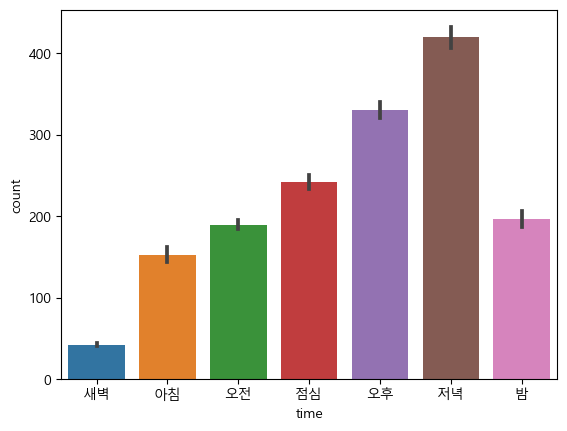

F_onewayResult(statistic=971.6523606007573, pvalue=0.0)

In [74]:
# 시각화
# x축 : 새벽, 아침, 오전, 점심, 오후, 저녁
# y축 : 자전거 대여량
sns.barplot(x=df["time"], y=df["count"])
plt.show()

# 수치화
L = []
for element in df["time"].unique():
    L.append(df.loc[df["time"] == element, "count"])
stats.f_oneway(*L)

* 오후, 저녁 (14시 ~ 21시)이 자전거 대여량이 압도적으로 높은 것을 알 수 있다.

3. 날짜(일요일, 월요일 ... 금요일)와 시간대별을 바탕으로 자전거 대여량 평균 확인


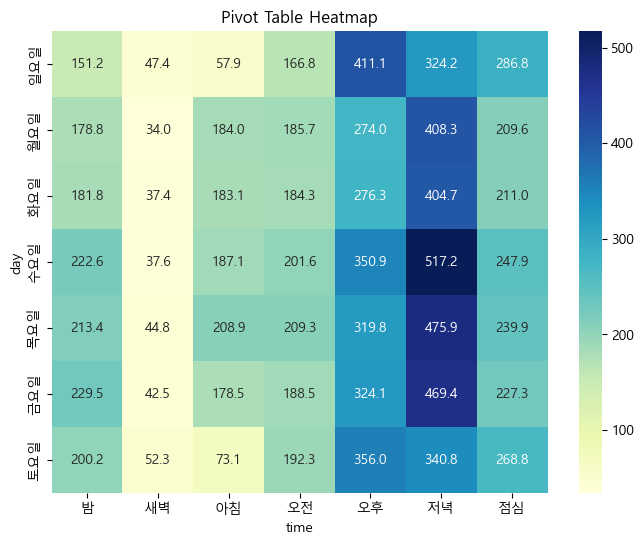

In [75]:
# 피벗 테이블 생성
pivot_table = df.pivot_table(index="day", columns='time', values='count', aggfunc='mean')

# 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.1f')  # 실수 형식으로 표현 (.1f)
plt.title('Pivot Table Heatmap')
plt.show()

* 수요일, 목요일, 금요일 저녁(18시 ~ 21시)에 자전거 대여량이 높다

3. 온도 데이터와 따릉이 대여량간 분석

In [76]:
# 온도를  쌀쌀한 날씨: (-3.5 <= < 0), 서늘한 날씨(0 <= < 10), 따뜻한 날씨: (10 <= < 25), 더운 날씨: (25 <= < 30), 
# 매우 더운 날씨: (30 <= < 36.4)로 분류하여 온도가 어떠한 겨울에 자전거 대여량이 높은지 확인한다.
def category_temperature(temperature):
    if -3.5 <= temperature < 0:
        return "쌀쌀한 날씨"
    elif 0 <= temperature < 10:
        return "서늘한 날씨"
    elif 10 <= temperature < 25:
        return "따뜻한 날씨"
    elif 25 <= temperature < 30:
        return "더운 날씨"
    else:
        return "매우 더운 날씨"
df["weather"] = df["temperature"].apply(category_temperature)

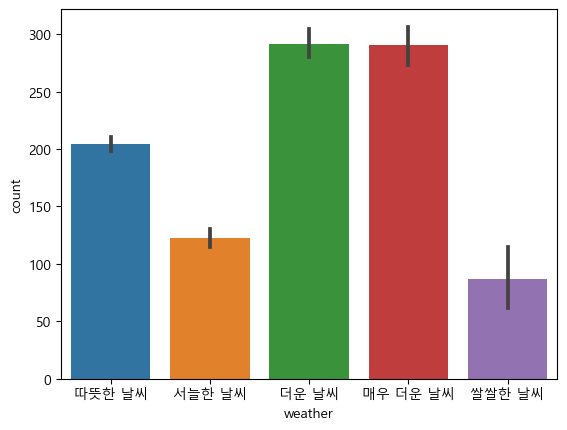

F_onewayResult(statistic=121.55416173385122, pvalue=8.911711252667439e-100)

In [77]:
# 시각화
# x축 : 쌀쌀한 날씨, 서늘한 날씨, ... 매우 더운 날씨
# y축 : 쌀쌀한 날씨 별 자전거 대여량 합 평균, ...., 매우 더운 날씨 별 자전거 대여량 합 평균
sns.barplot(x=df["weather"], y=df["count"])
plt.show()

# 수치화
L = []
for element in df["weather"].unique():
    L.append(df.loc[df["weather"] == element, "count"])
stats.f_oneway(*L)

* 더운 날씨, 매우 더운 날씨(25 ~ 36.4)에 자전거 대여량이 압도적으로 많다

4. 날짜(4월, 5월 ... 11월), 날씨(쌀쌀한 날씨, 서늘한 날씨, ... 매우 더운 날씨)를 바탕으로 자전거 대여량 평균 분석

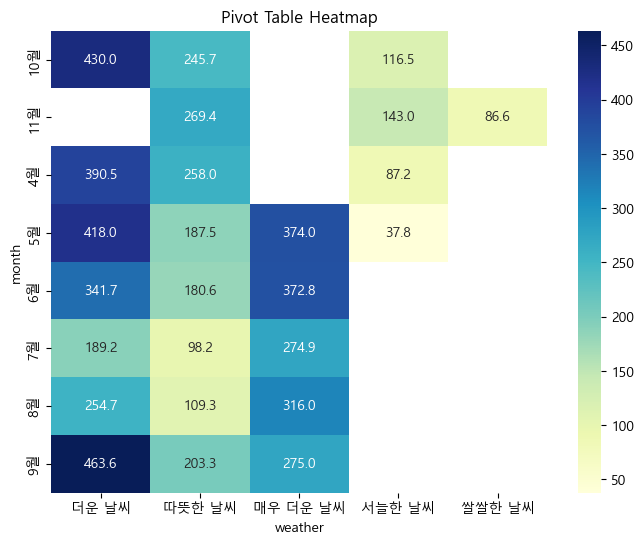

In [78]:
# 피벗 테이블 생성
pivot_table = df.pivot_table(index="month", columns='weather', values='count', aggfunc='mean')

# 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.1f')  # 실수 형식으로 표현 (.1f)
plt.title('Pivot Table Heatmap')
plt.show()

* 더운 날씨인 25 ~ 29도 5월에 자전거 대여량 평균 수가 매우 많다.
* 더운 날씨인 25 ~ 29도 9월에 자전거 대여량 평균 수가 매우 많다.
* 더운 날씨인 25 ~ 29도인 10월에 자전거 대여량 평균 수가 매우 많다.

4. 풍속 데이터와 따릉이 대여량간 분석

In [85]:
# 풍속을 바람 없음(0 <= < 0.3), 약한 바람: (0.3 <= < 3.4), 약간 강한 바람: (3.4 <= < 8.0), 강한 바람: (8.0 <= < 10.0)으로 분류하여 
# 어떠한 풍속일 떄 자전거 대여량이 높은지 확인한다.
def category_wind(wind):
    if 0 <= wind < 0.3:
        return "바람 없음"
    elif 0.3 <= wind < 3.4:
        return "약한 바람"
    elif 3.4 <= wind < 8.0:
        return "약간 강한 바람"
    else:
        return "강한 바람"
df["windStrength"] = df["windspeed"].apply(category_wind)

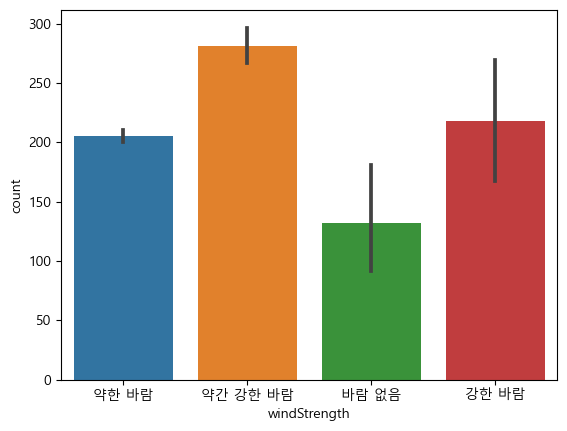

F_onewayResult(statistic=41.54021634414594, pvalue=1.4897443950234392e-26)

In [89]:
# 시각화
# x축 : 약한 바함, 강한 바람 ..
# y축 : 약한 바람일 떄 자전거 대여량 평균 수, 강한 바람일 떄 자전거 대여량 평균 수 
sns.barplot(x=df["windStrength"], y=df["count"])
plt.show()

# 수치화
L = []
for element in df["windStrength"].unique():
    L.append(df.loc[df["windStrength"] == element, "count"])
stats.f_oneway(*L)

* 약한 강한 바람(3.4 ~ 7.9)일 떄 자전거 대여량이 평균적으로 높다.

5. 온도(ex. 더운 날씨, 매우 더운 날씨)와 풍속(ex. 약한 바람, 약간 강한 바람) 연관성 찾기

In [90]:
df.head()

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count,month,day,time,weather,windStrength
0,2021-04-01,1,42.0,21.0,0.002,13.1,0,1.4,49,2000,46,4월,목요일,새벽,따뜻한 날씨,약한 바람
1,2021-04-01,2,41.0,21.0,0.003,12.4,0,2.1,53,2000,40,4월,목요일,새벽,따뜻한 날씨,약한 바람
2,2021-04-01,3,30.0,13.0,0.023,13.1,0,3.4,43,2000,31,4월,목요일,새벽,따뜻한 날씨,약간 강한 바람
3,2021-04-01,4,27.0,12.0,0.028,13.0,0,3.1,44,2000,12,4월,목요일,새벽,따뜻한 날씨,약한 바람
4,2021-04-01,5,29.0,14.0,0.008,13.0,0,2.9,44,2000,30,4월,목요일,새벽,따뜻한 날씨,약한 바람


5. 습도 데이터와 따릉이 대여량간 분석

In [104]:
# 습도(humidity) 건조: (19 <=  < 41), 보통: (41 <=  < 60), 습함: (60 <= < 80), 매우 습함: (80 <= < 101)으로 분류하여
#어떠한 습도일 떄 자전거 대여량이 높은지 확인한다.
def category_humidity(humidity):
    if 19 <= humidity < 41:
        return "건조"
    elif 41 <= humidity < 60:
        return "보통"
    elif 60 <= humidity < 80:
        return "습함"
    elif 80 <= humidity < 101:
        return "매우 습함"
df["humidCategory"] = df["humidity"].apply(category_humidity)

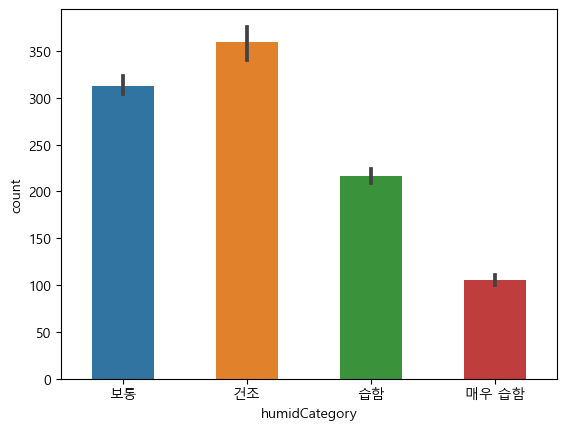

F_onewayResult(statistic=521.498087710674, pvalue=3.492954240514575e-300)

In [105]:
# 시각화
# x축 : 건조, 보통, 습함, 매우 습합
# y축 : 건조할 떄 자전거 대여량 평균 ...
sns.barplot(x=df["humidCategory"], y=df["count"], width=0.5)
plt.show()

# 수치화
L = []
for element in df["humidCategory"].unique():
    L.append(df.loc[df["humidCategory"] == element, "count"])
stats.f_oneway(*L)

* 습도가 보통 ~ 건조 (19 ~ 59)일 떄 자전거 대여량 평균이 높다.

5. 날짜(ex. 4월, 6월, 9월...), 습도(보통, 건조, ... ) 간 분석

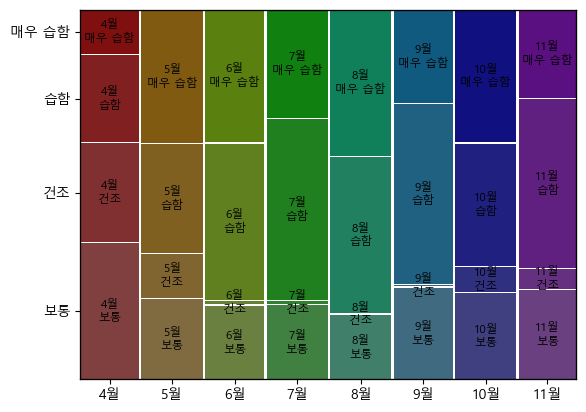

Chi2ContingencyResult(statistic=983.6613500731522, pvalue=8.453111066744773e-195, dof=21, expected_freq=array([[ 49.15737086, 224.46404668, 176.2004462 , 294.17813626],
       [ 46.05199931, 210.28419427, 165.06950403, 275.59430239],
       [ 47.37343401, 216.31817402, 169.80607517, 283.5023168 ],
       [ 49.09129912, 224.16234769, 175.96361764, 293.78273554],
       [ 47.57164922, 217.22327098, 170.51656084, 284.68851896],
       [ 49.15737086, 224.46404668, 176.2004462 , 294.17813626],
       [ 49.15737086, 224.46404668, 176.2004462 , 294.17813626],
       [ 47.43950575, 216.619873  , 170.04290372, 283.89771752]]))

In [107]:
from statsmodels.graphics.mosaicplot import mosaic
# 시각화
mosaic(df, ["month", "humidCategory"])
plt.show()

# 수치화
cross_table = pd.crosstab(df["month"], df["humidCategory"])
stats.chi2_contingency(cross_table)

* 날짜(4월, 5월 .. 11월)와 습도(건조, 보통)은 강한 연관 관계를 가지고 있다.

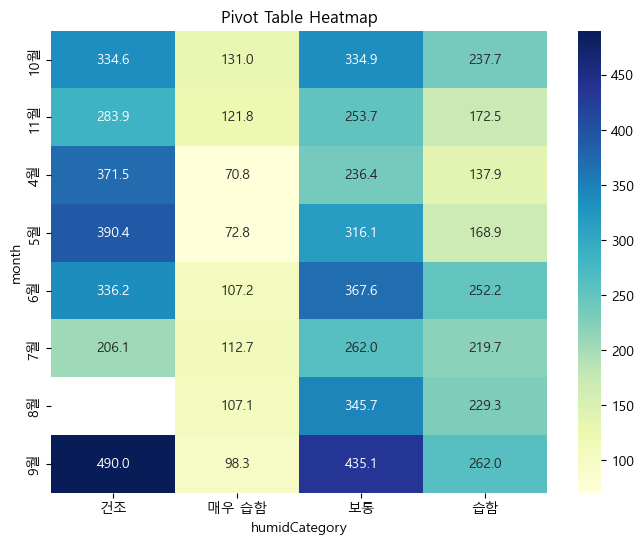

In [108]:
pivot_table = df.pivot_table(index="month", columns='humidCategory', values='count', aggfunc='mean')

# 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.1f')  # 실수 형식으로 표현 (.1f)
plt.title('Pivot Table Heatmap')
plt.show()

* 9월 습도가 보통이거나 건조할 떄 자전거 대여량이 가장 많은 것을 알 수 있다.

5. 시간대(오전, 오후, 저녁...) 습도(보통, 건조) 연관 분석

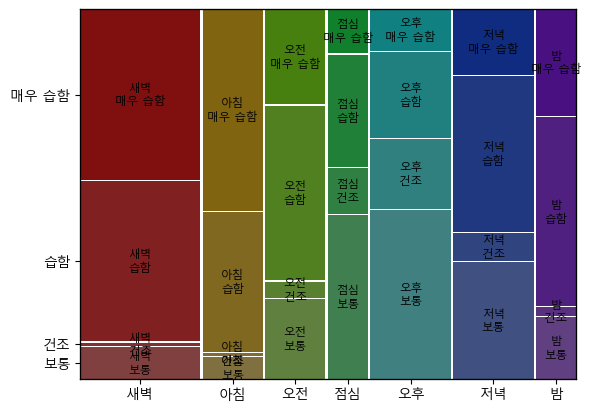

Chi2ContingencyResult(statistic=1568.5402670877147, pvalue=0.0, dof=18, expected_freq=array([[ 32.11086322, 146.62570791, 115.09867857, 192.1647503 ],
       [ 96.06830273, 438.67032778, 344.34872147, 574.91264802],
       [ 48.1002231 , 219.63686288, 172.41118929, 287.85172473],
       [ 48.16629483, 219.93856187, 172.64801785, 288.24712545],
       [ 64.22172645, 293.25141582, 230.19735713, 384.3295006 ],
       [ 64.22172645, 293.25141582, 230.19735713, 384.3295006 ],
       [ 32.11086322, 146.62570791, 115.09867857, 192.1647503 ]]))

In [109]:
# 시각화
mosaic(df, ["time", "humidCategory"])
plt.show()

# 수치화
cross_table = pd.crosstab(df["time"], df["humidCategory"])
stats.chi2_contingency(cross_table)

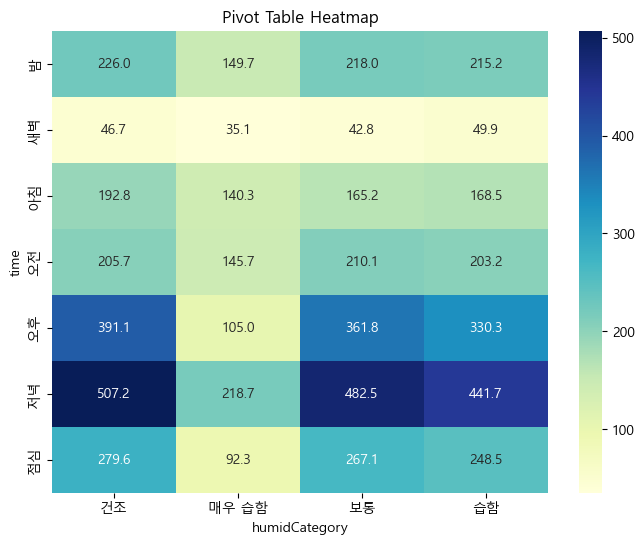

In [111]:
pivot_table = df.pivot_table(index="time", columns='humidCategory', values='count', aggfunc='mean')

# 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.1f')  # 실수 형식으로 표현 (.1f)
plt.title('Pivot Table Heatmap')
plt.show()

* 주로 오후 ~ 저녁이면서 습도가 보통 ~ 건조일 떄 자전거 대여량 평균이 높은 것을 재확인했다.

6. 시정 데이터와 따릉이 대여량간 분석

In [81]:
#데이터 타입에 주의하여 이변량 분석을 해보세요

7. 오존 데이터와 따릉이 대여량간 분석

In [82]:
#데이터 타입에 주의하여 이변량 분석을 해보세요

8. 미세먼지 농도 데이터와 따릉이 대여량간 분석

In [112]:
# 미세먼지(PM10)을 좋음 (0 <= < 31), 보통 (31 <=  < 81), 나쁨 (81 <=  < 151), 매우 나쁨 (151 <=  < 250), 위험 (250 <= < 828)으로 분류하여
# 미세먼지가 어떠한 경우에 자전거 대여량이 높은가?
def category_PM10(PM10):
    if 0 <= PM10 < 31:
        return "좋음"
    elif 31 <= PM10 < 81:
        return "보통"
    elif 81 <= PM10 < 151:
        return "나쁨"
    else:
        return "매우 나쁨"
df["category_PM10"] = df["PM10"].apply(category_PM10)

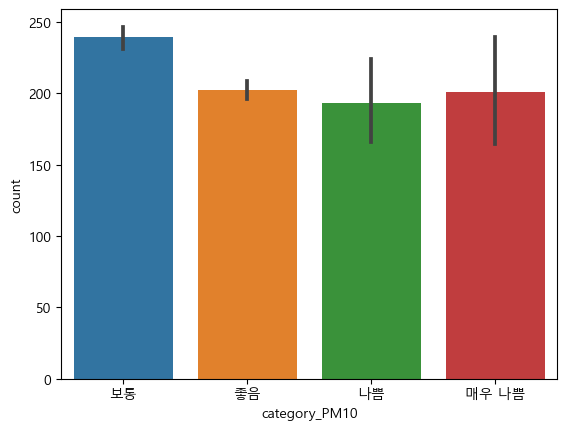

F_onewayResult(statistic=18.396308492448572, pvalue=7.0933081064829544e-12)

In [115]:
# 시각화
# x축 : 미세먼지 보통, 좋음, 나쁨, 매우 나쁨
# y축 : 미세먼지 보통일 떄 자전거 대여량 평균 수 ...
sns.barplot(x=df["category_PM10"], y=df["count"])
plt.show()

# 수치화
L = []
for element in df["category_PM10"].unique():
    L.append(df.loc[df["category_PM10"] == element, "count"])
stats.f_oneway(*L)

* 미세먼지 보통일 때 자전거 평균 대여량 수가 높으나
* 딱히 미세먼지 정도가 자전거 대여량과 많이 연관되어 있는 것은 아닌 것 같다.

9. 초미세먼지 농도 데이터와 따릉이 대여량간 분석

In [84]:
#데이터 타입에 주의하여 이변량 분석을 해보세요

### [Step5] 가설 검정

#### <font color='green'>1. 강한 관계의 변수 (대립가설 채택)</font>

#### <font color='green'>2. 약한 관계의 변수</font>


#### <font color='green'>3. 관계 없는 변수 (귀무가설 채택)</font>


### [Step6] Insight 도출 (우선 고려 사항)

 출근, 퇴근 시 사람들이 자전거를 많이 이용한다.<br>
 따라서 아침에는 거주지역 주변에 자전거를 많이 배치하고<br>
 오후에서 저녁 넘어가는 시점에 회사 주변에 자전거를 많이 배치한다.<br>
 
 25도가 넘어가는 더운 날씨일 떄 사람들은 자전거를 많이 이용한다.<br>
 따라서 서늘한 날씨 (0 ~ 10)일 떄 자전거를 전체적으로 수리하고, <br>
 따뜻한 날씨, 더운 날씨일 떄 사람들이 자전거를 문제 없이 사용하도록 해야 한다.<br>
  
 온도와 연관되는 습도<br>
 습도가 보통, 건조일 떄 즉 기온이 어느정도 있을 떄  자전거를 많이 이용하는 것을 알 수 있다.<br>


## [Step6] Insight 도출 (차기 고려 사항)

4월, 6월  9월, 10월에 자전거를 많이 이용한다.

수요일, 목요일, 금요일에 자전거를 많이 이용한다.

기본적으로 비가 오지 않아야 한다.

미세먼지가 이슈가 되지 않는 농도가 자전거 대여가 높음을 알 수 있다.

사람들이 바람이 어느정도 불 떄 라고 느끼는 풍속 정도가 자전거 대여가 높음을 알 수 있다.
